# 1. Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# For feature selection
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# For model development
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# For model interpretation
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# 2. Data loading, cleaning and preprocessing

Preprocessing strategy: Multiplicative Scatter Correction followed by Standardisation, decided by trial and error (not shown here)

In [16]:
print("Loading and processing data from Excel sheets...")

# File path and sheet names
excel_file = 'Data for modelling.xlsx'
sheet_names = ["Condition 1 Day 0", "Condition 2 Day 0", "Condition 3 Day 0"]

# Create lists to store features and labels, and build feature names
features_list = []
labels_list = []
feature_names = [f"MSC_{i+1}" for i in range(125)] # there are 125 wavelengths in each original spectrum

# Define functions for data cleaning and preprocessing

def clean_spectral_data(df_spectra):
    """
    Remove unwanted patterns (e.g., '+C19') from spectral data.
    """
    return df_spectra.apply(lambda col: col.astype(str).str.replace(r'\+C\d+', '', regex=True))

def compute_msc(spectra):
    """
    Apply Multiplicative Scatter Correction (MSC)
    """
    mean_spectrum = np.mean(spectra, axis=0)
    corrected_data = np.zeros_like(spectra)
    for i in range(spectra.shape[0]):
        fit = np.polyfit(mean_spectrum, spectra[i, :], 1, full=True)
        corrected_data[i, :] = (spectra[i, :] - fit[0][1]) / fit[0][0]
    return corrected_data

for idx, sheet in enumerate(sheet_names):
    df = pd.read_excel(excel_file, sheet_name=sheet, header=None)
    
    # Spectral data starts from second row and first column (wavelengths in the first row)
    spectra_df = df.iloc[1:, 0:].copy()
    spectra_df = clean_spectral_data(spectra_df)
    X_original = spectra_df.astype(np.float32).values
    
    # Apply MSC followed by Standardisation
    X_msc = compute_msc(X_original)
    X_std_msc = StandardScaler().fit_transform(X_msc)
    
    features_list.append(X_std_msc)
    labels_list.append(np.full(X_original.shape[0], idx))
    
# Concatenate data from all sheets
X_all = np.vstack(features_list)
y_all = np.concatenate(labels_list)

print(f"Combined data shape: {X_all.shape}")

Loading and processing data from Excel sheets...
Combined data shape: (67, 125)


# 3. Split data into Training, Validation and Test sets

Training and Validation sets are used for 
(i)  feature selection (Step 4), and
(ii) model building/hyperparameter tuning (Step 5)

Test set is held out for Model Evaluation in Step 6 only.

In [17]:
print("\nSplitting data into training, validation, and test sets...")

# Reserve 15% for testing. Fix random seed for reproducibility. Change to generate new folds.
X_temp, X_test, y_temp, y_test = train_test_split(
    X_all, y_all,
    test_size=0.15,
    stratify=y_all,
    random_state=1
)

# Split the remaining 85% into training and validation sets (15% of 85% ~ 17.65% total).
val_fraction = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_fraction,
    stratify=y_temp,
    random_state=1
)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Splitting data into training, validation, and test sets...
Training set shape: (46, 125)
Validation set shape: (10, 125)
Test set shape: (11, 125)


# 4. Feature selection

Using Recursive Feature Elimination and Random Forest Classifier.
Only Training and Validation sets are used; Test set is not seen here.

In [18]:
print("\nPerforming RFE to select the top features...")

# Define the base estimator for RFE. Fix random state for reproducibility
rfe_estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Setting verbose=1 will show progress information during RFE
selector = RFE(
    estimator=rfe_estimator,
    n_features_to_select=30,  # Select top 30 features, change if needed
    step=1,
    verbose=1
)

# Fit on the training set
selector.fit(X_train, y_train)

# Transform train, validation, and test sets
X_train_rfe = selector.transform(X_train)
X_val_rfe   = selector.transform(X_val)
X_test_rfe  = selector.transform(X_test)

print(f"After RFE, number of selected features: {X_train_rfe.shape[1]}")

# Get the indices of the selected features
selected_feature_indices = np.where(selector.support_)[0]

print("Selected feature indices:", selected_feature_indices)


Performing RFE to select the top features...
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 fe

# 5. Model development

Train Artificial Neural Network on training set only and Monitor performance  using the validation set

In [33]:
# Fix random seeds for reproducibility. Can be changed to try different model initialisation weights
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

num_classes = 3
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
final_input_dim = X_train_rfe.shape[1]

# Set and tune hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.01
num_hidden_layer_nodes = 3

# Build the initial model
model = Sequential([
    Input(shape=(final_input_dim,)),
    Dense(num_hidden_layer_nodes, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

print("\n--- Training on Training Set Only ---")

# Fit training data to the model and store the training information for later analysis
history = model.fit(
    X_train_rfe, y_train_cat,
    validation_data=(X_val_rfe, y_val_cat),
    epochs=epochs, batch_size=batch_size, verbose=1
)


--- Training on Training Set Only ---
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step - accuracy: 0.3424 - loss: 1.2778 - val_accuracy: 0.2000 - val_loss: 1.3208
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3673 - loss: 1.1832 - val_accuracy: 0.2000 - val_loss: 1.2681
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4171 - loss: 1.1202 - val_accuracy: 0.2000 - val_loss: 1.2329
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4918 - loss: 1.0907 - val_accuracy: 0.3000 - val_loss: 1.2070
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4171 - loss: 1.0788 - val_accuracy: 0.2000 - val_loss: 1.1805
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3922 - loss: 1.0775 - val_accuracy: 0.2000 - val_loss: 1.1699
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4253 - loss: 1.0755 - val_accuracy: 0.2000 - val_loss: 1.1744
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4253 - 

# 6. Evaluation on Test Set

In [35]:
# Get the predictions of classes on the test set
pred_test = np.argmax(model.predict(X_test_rfe), axis=1)

acc_test  = accuracy_score(y_test, pred_test)
conf_matrix = confusion_matrix(y_test, pred_test)

print(f"\nFinal Test Accuracy: {acc_test:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Also get the predictions on the training set for recording later
pred_train = np.argmax(model_final.predict(X_train_rfe), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Final Test Accuracy: 0.1818
Confusion Matrix:
[[0 3 0]
 [0 1 3]
 [0 3 1]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


# 7. Extract Principal Components (PCs) of Hidden Layer Activations and Plot


Computing and Plotting PCs of Hidden Layer Activations...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 


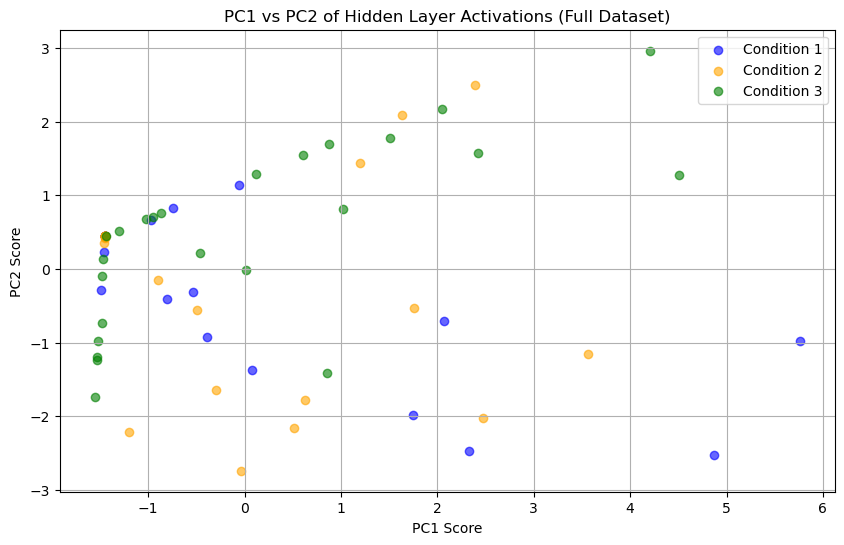

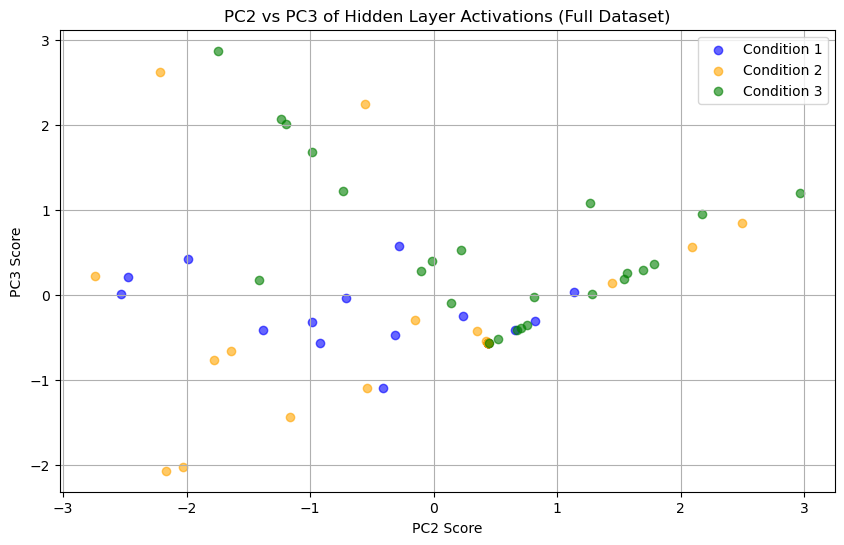

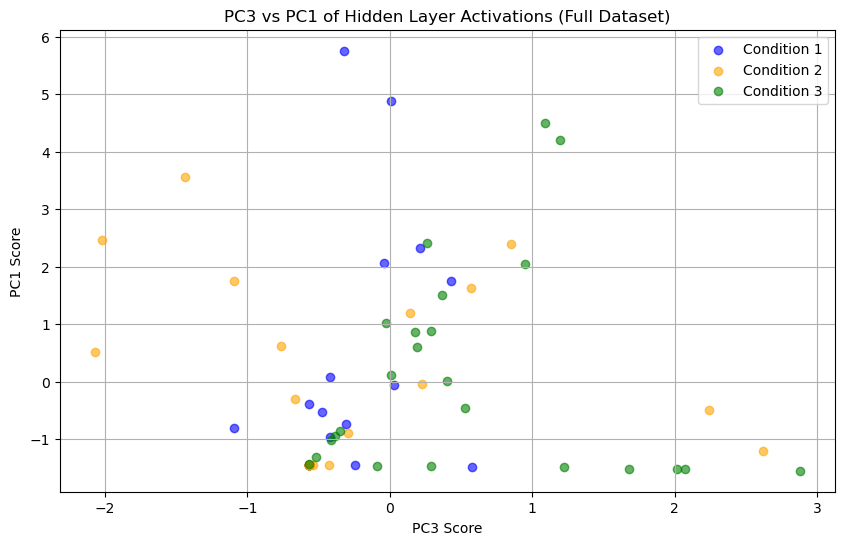

In [36]:
print("\nComputing and Plotting PCs of Hidden Layer Activations...")

# Combine full dataset (training, validation, and test) in RFE-space
X_full_rfe = np.vstack((X_train_rfe, X_val_rfe, X_test_rfe))
y_full     = np.concatenate((y_train, y_val, y_test))

# Force a dummy pass so the model's input is defined.
dummy_input = np.zeros((1, final_input_dim))
_ = model(dummy_input)

# Extract the hidden layer activations using the first input tensor.
hidden_layer_model = tf.keras.Model(
    inputs=model.inputs[0],
    outputs=model.layers[-2].output
)
hidden_activations = hidden_layer_model.predict(X_full_rfe)

# Perform PCA on the hidden activations to reduce to 3 principal components.
pca = PCA(n_components=3)
pcs = pca.fit_transform(hidden_activations)

# Define condition names and their colours for plotting
condition_names = {0: "Condition 1", 1: "Condition 2", 2: "Condition 3"}
colors = ['blue', 'orange', 'green']

# Plot PC1 vs. PC2, PC2 vs. PC3, PC3 vs. PC1
pairs = [(0, 1), (1, 2), (2, 0)]

for x_idx, y_idx in pairs: # x_idx refers to the PC being plotted on the x-axis, y_idx refers to the PC being plotted on the y-axis
    plt.figure(figsize=(10, 6))
    
    for cond in range(num_classes):
        cond_idx = np.where(y_full == cond)[0]
        x_scores = pcs[cond_idx, x_idx]
        y_scores = pcs[cond_idx, y_idx]
        
        plt.scatter(x_scores, y_scores, color=colors[cond], alpha=0.6, label=condition_names[cond])
    
    plt.xlabel(f"PC{x_idx+1} Score")
    plt.ylabel(f"PC{y_idx+1} Score")
    plt.title(f"PC{x_idx+1} vs PC{y_idx+1} of Hidden Layer Activations (Full Dataset)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 8. Compute Permutation Feature Importance

In [37]:
class KerasClassifierWrapper:
    """Wrapper for Keras model to enable use with permutation_importance."""
    def __init__(self, keras_model):
        self.model = keras_model
        
    def fit(self, X, y):
        # The fit function is not required for permutation_importance since it uses the trained model
        pass
    
    def predict(self, X):
        """Predicts class labels using the trained model."""
        pred_probabilities = self.model.predict(X)    # Get the predicted probabilities
        return np.argmax(pred_probabilities, axis=1)  # Return the class with the highest probability i.e., predicted class

print("\nComputing permutation importance...")

# Wrap the trained model for use with permutation importance
wrapper_clf = KerasClassifierWrapper(model)

# Calculate permutation importance with accuracy as the scoring method
perm_imp_class = permutation_importance(
    wrapper_clf, 
    X_test_rfe, 
    y_test, 
    scoring='accuracy',
    n_repeats=10,
    random_state=1     # Fix for reproducibility
)

# Extract the mean importance values for each feature
importances_cls = perm_imp_class.importances_mean


Computing permutation importance...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━

# 9. Plot Learning Curve


Plotting Learning Curve...


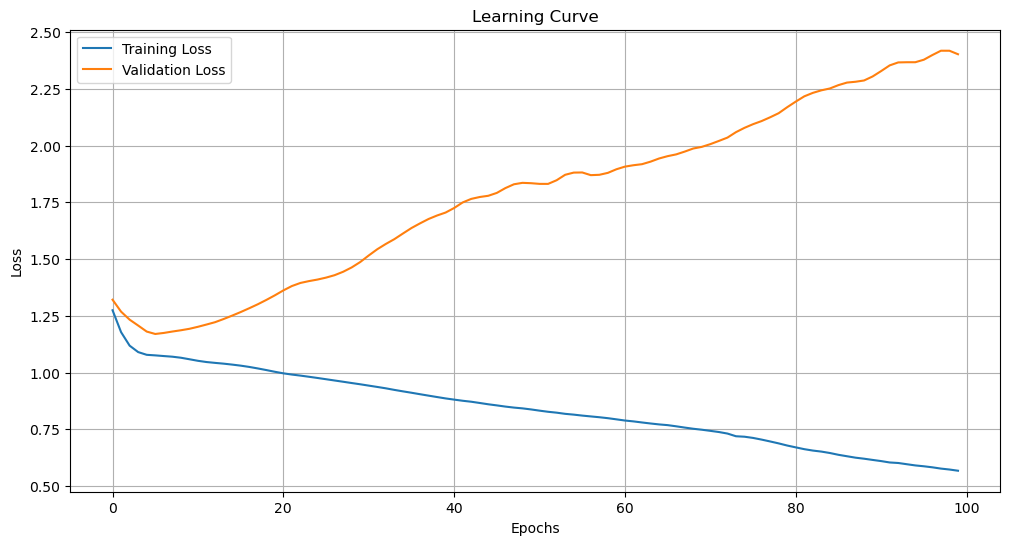

In [42]:
print("\nPlotting Learning Curve...")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# 10. Save predictions, selected features with feature importance and PCs to Excel

In [41]:
# Create DataFrame for Train predictions
df_train_pred = pd.DataFrame({
    "ActualLabel": y_train,
    "PredLabel": pred_train
})

# Create DataFrame for Test predictions
df_test_pred = pd.DataFrame({
    "ActualLabel": y_test,
    "PredLabel": pred_test
})
    
# Create a Dataframe for feature importance
selected_feature_names = [feature_names[idx] for idx in selected_feature_indices]

df_importance = pd.DataFrame({
    "SelectedFeatureIndex": selected_feature_indices,
    "SelectedFeatureName": selected_feature_names,
    "ClassImportance_Acc": importances_cls
})
df_importance_sorted = df_importance.sort_values("ClassImportance_Acc", ascending=False)

df_pcs = pd.DataFrame({
    "ActualLabel": y_full,
    "ConditionName": pd.Series(y_full).map(condition_names),
    "PC1": pcs[:, 0],
    "PC2": pcs[:, 1],
    "PC3": pcs[:, 2]
})

# Save all DataFrames to an Excel file with multiple sheets. Version file name to avoid overwriting.
output_excel = "prediction_results_v1.xlsx"
with pd.ExcelWriter(output_excel) as writer:
    df_train_pred.to_excel(writer, sheet_name="TrainValPredictions", index=False)
    df_test_pred.to_excel(writer, sheet_name="TestPredictions", index=False)
    df_importance_sorted.to_excel(writer, sheet_name="SelectedFeatures", index=False)
    df_pcs.to_excel(writer, sheet_name="PCs", index=False)

print(f"\nAll results have been saved to '{output_excel}'.")


All results have been saved to 'prediction_results_v1.xlsx'.
